In [19]:
# ruff: noqa
import sys, os
sys.path.append(os.path.abspath("./../../../feedback-grape"))
sys.path.append(os.path.abspath("./../../feedback-grape"))
sys.path.append(os.path.abspath("./../../../"))
sys.path.append(os.path.abspath("./../../"))
sys.path.append(os.path.abspath("./../"))

# ruff: noqa
from helpers import (
    generate_povm2,
    generate_unitary,
)
from library.utils.plot_matrix import plot_matrix
import jax
import jax.numpy as jnp
import numpy as np
import json
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)


N_chains = 3

files = [
    #"lut_t=2_l=2_w=11_noise=0.5_i=1000",
    "lut_t=3_l=2_w=111_noise=0.0",
    "lut_t=3_l=2_w=111_noise=0.5",
    "lut_t=3_l=2_w=111_noise=1.0",
    "lut_t=3_l=2_w=111_noise=inf",
]

# open all files and generate operators from optimized parameters
def extract_operators(meas, flattened_params):
    povm_params = jnp.array(flattened_params[:4**N_chains])
    unitary_params = jnp.array(flattened_params[4**N_chains:])

    povm = generate_povm2(meas, povm_params, 2**N_chains)
    unitary = generate_unitary(unitary_params, 2**N_chains)
    return povm, unitary

ops = []
variables = []
for j,file in enumerate(files):
    with open(f"{file}.json", "r") as f:
        params_lut = json.load(f)["optimized_trainable_parameters"]

    povm_init_p, _ = extract_operators( 1, params_lut["initial_params"][4] + params_lut["initial_params"][5])
    povm_init_m, _ = extract_operators(-1, params_lut["initial_params"][4] + params_lut["initial_params"][5])

    ops_here = [
        jnp.abs(povm_init_p @ povm_init_p.conj().T),
    ]

    if j == 0:
        variables.extend(
            ["$\\mathrm{|POVM_{\\mathrm{init},+}|}^2$"]
        )

    for t,col in enumerate(params_lut["lookup_table"]):
        for meas_hist,params in enumerate(col):
            meas = 1 if meas_hist % 2 == 0 else -1
            povm, unitary = extract_operators(meas, params)

            meas_bin = bin(meas_hist).replace('1', '-').replace('0', '+')[2:]

            if meas == 1:
                ops_here.append( jnp.abs(povm_init_p @ povm.conj().T) ) # only need one povm due to completeness
            ops_here.append( jnp.abs(unitary) )

            if j == 0:
                if meas == 1:
                    variables.append( f"$\\mathrm{{|POVM_{{{meas_bin}}}|}}^2$" )
                

                variables.append(f"$\\mathrm{{|U_{{{meas_bin}}}|}}$")


    top_label = "$\\varepsilon = $" + file.split("noise=")[1]
    ops.append( (top_label, ops_here) )

# Extract labels and matrices from ops
labels = [op[0] for op in ops]

variables_flat = variables#[var for sublist in variables for var in sublist]

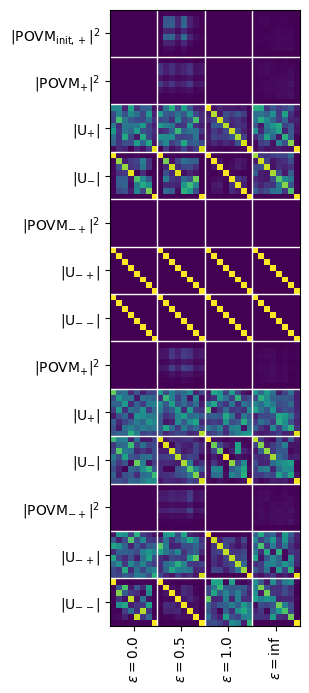

In [22]:
# Define padding size
padding = 1

# Calculate the size of the combined matrix
matrix_shape = povm_init_m.shape  # Assuming all matrices are the same shape
rows = len(variables_flat)
cols = len(labels)
combined_matrix = np.zeros(
    (
        rows * matrix_shape[0],
        cols * matrix_shape[1],
    )
)

# Fill the combined matrix with individual matrices
all_matrices = []
for col, (label, matrices) in enumerate(ops):
    all_matrices.extend(matrices)
    for row,matrix in enumerate(matrices):
        start_row = row * matrix_shape[0]
        start_col = col * matrix_shape[1]
        combined_matrix[
            start_row : start_row + matrix_shape[0], start_col : start_col + matrix_shape[1]
        ] = np.abs(matrix)

# Plot the combined matrix
fig, ax = plt.subplots(figsize=(20, 8))
im = ax.imshow(combined_matrix, vmin=0, vmax=1, cmap="viridis")

# Add white lines for padding
for row in range(1, rows):
    ax.axhline(
        y=row * matrix_shape[0] - 0.5,
        color="white",
        linewidth=padding,
    )
for col in range(1, cols):
    ax.axvline(
        x=col * matrix_shape[1] - 0.5,
        color="white",
        linewidth=padding,
    )

# Finalize the plot
ax.set_xticks(
    [i * matrix_shape[1] + (matrix_shape[1] / 2) - 0.5 for i in range(cols)]
)
ax.set_xticklabels(labels, rotation=90)
ax.set_yticks(
    [i * matrix_shape[0] + (matrix_shape[0] / 2) - 0.5 for i in range(rows)]
)
ax.set_yticklabels(variables_flat)
#fig.colorbar(im, ax=ax, label="Absolute Value")
plt.show()

fig.savefig("00_optimized_parameters_overview.png", dpi=300)


In [21]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
import seaborn as sns

# Define the number of top groups to represent
N_representatives = 10

def find_common_matrices(matrix_class, N_representatives, do_plot=False):
    # Choose a matrix metric
    def matrix_distance(matrix1, matrix2):
        return np.linalg.norm(np.abs(matrix1) - np.abs(matrix2))

    # Compute pairwise distances
    distance_matrix = np.zeros((len(matrix_class), len(matrix_class)))
    for i in range(len(matrix_class)):
        for j in range(len(matrix_class)):
            distance_matrix[i, j] = matrix_distance(matrix_class[i], matrix_class[j])

    # Use t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, metric="precomputed", init="random", random_state=42, perplexity=min(30, len(matrix_class) - 1))
    embedding = tsne.fit_transform(distance_matrix)

    # Perform clustering on the distance matrix
    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0.5, metric="precomputed", linkage="average")
    labels = clustering.fit_predict(distance_matrix)

    # Count the size of each cluster
    unique_labels, counts = np.unique(labels, return_counts=True)
    sorted_indices = np.argsort(counts)[::-1]  # Sort clusters by size in descending order

    # Select the top N_representatives clusters
    top_clusters = unique_labels[sorted_indices[:N_representatives]]

    # Plot the t-SNE embedding with cluster representatives
    if do_plot:
        plt.figure(figsize=(5, 5))
        sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette="tab10", s=10, legend=None)
        plt.title("2D Associative Network of Matrices with Cluster Representatives")
        plt.xlabel("t-SNE Dimension 1")
        plt.ylabel("t-SNE Dimension 2")

    # Represent each cluster by the mean of its matrices
    representatives = []
    for cluster in top_clusters:
        cluster_indices = np.where(labels == cluster)[0]
        
        representative_matrix = np.mean([np.abs(matrix_class[idx]) for idx in cluster_indices], axis=0).reshape(4, 4)
        representatives.append(representative_matrix)

    return representatives, top_clusters

representatives, top_clusters = find_common_matrices(all_matrices, N_representatives=N_representatives, do_plot=False)

# Plot the representatives in a separate figure
fig, axes = plt.subplots(1, len(top_clusters), figsize=(10, 2))
for i, representative_matrix in enumerate(representatives):
    # Plot the representative matrix
    ax = axes[i]
    im = ax.imshow(np.abs(representative_matrix), cmap="viridis", vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Cluster {i+1}", fontsize=8)

# Add a colorbar to the figure
plt.suptitle("Representative Matrices of Top Clusters", fontsize=14)
plt.tight_layout()
plt.show()



from feedback_grape.utils.states import basis
from feedback_grape.utils.operators import identity

I = identity(4)
psi_00 = basis(4, 3)
psi_01 = basis(4, 2)
psi_10 = basis(4, 1)
psi_11 = basis(4, 0)
rho_00 = psi_00 @ psi_00.conj().T
rho_01 = psi_01 @ psi_01.conj().T
rho_10 = psi_10 @ psi_10.conj().T
rho_11 = psi_11 @ psi_11.conj().T

swap_00_11 = psi_00@psi_11.conj().T + psi_11@psi_00.conj().T + rho_01 + rho_10 # |00> <-> |11> swap

test_matrices = [
    I,
    rho_00,
    rho_00 + rho_11,
    I - rho_00,
    rho_00 + rho_01 + psi_11@psi_10.conj().T + psi_10@psi_11.conj().T, # CNOT where first qubit is control
    rho_00 + rho_10 + psi_11@psi_01.conj().T + psi_01@psi_11.conj().T, # CNOT where second qubit is control
    swap_00_11,
    1/3 * I + 2/3 * swap_00_11,
    psi_11@psi_01.conj().T + psi_10@psi_00.conj().T + psi_01@psi_10.conj().T + psi_00@psi_11.conj().T, # CNOT with first qubit as control followed by NOT on first qubit
    1/2*(psi_11@psi_10.conj().T + psi_11@psi_01.conj().T + psi_10@psi_00.conj().T + psi_01@psi_00.conj().T # Randomly flips first or second qubit
         + psi_10@psi_11.conj().T + psi_01@psi_11.conj().T + psi_00@psi_10.conj().T + psi_00@psi_01.conj().T),
    psi_00@psi_11.conj().T + psi_11@psi_00.conj().T + psi_01@psi_10.conj().T + psi_10@psi_01.conj().T, # Not on both qubits
]

# Plot the representatives in a separate figure
fig, axes = plt.subplots(1, len(test_matrices), figsize=(10, 2))
for i, matrix in enumerate(test_matrices):
    # Plot the representative matrix
    ax = axes[i]
    im = ax.imshow(np.abs(matrix), cmap="viridis", vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Matrix {i+1}", fontsize=8)

# Add a colorbar to the figure
plt.suptitle("Matrices for comparison", fontsize=14)
plt.tight_layout()
plt.show()


ValueError: cannot reshape array of size 64 into shape (4,4)